<a href="https://colab.research.google.com/github/LeandroMAcosta/clustering_nlp/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U spacy==3.1.2
!python -m spacy download es_core_news_md

In [ ]:
import spacy
import pickle
import matplotlib.pyplot as plt
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster import cosine_distance
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import random

In [ ]:
# Settings
ROOTCORPUS = "./corpus/"
file_name = "lavoztextodump.txt"
# MAX_LINES = 30000
MAX_LINES = 1000000
NUMBER_OF_CLUSTERS = 6
NUMBER_OF_ITERATIONS = 600
THRESHOLD_WORD = 30
THRESHOLD_CONTEXT = 15
THRESHOLD_VECTOR = 0.001
CONTEXT_SIZE = 2

In [ ]:
filename_path = ROOTCORPUS + file_name
text_file = open(filename_path, "r")
corpus = text_file.read()
text_file.close()
nlp = spacy.load("es_core_news_md")
doc = nlp(corpus[:MAX_LINES])

In [ ]:
sents = [sent for sent in doc.sents if len(sent) > 5]

words = []
words_lemma = []
for sent in sents:
    for word in sent:
        if word.is_alpha:
            words.append(word)
            words_lemma.append(word.lemma_)
            
counts_lemma = Counter(words_lemma)

In [ ]:
def build_features(words, counts_lemma):
    features = defaultdict(lambda:defaultdict(int))
    for i, word in enumerate(words):
        lemma_str = word.lemma_
        if counts_lemma[lemma_str] < THRESHOLD_WORD or word.like_num:
            continue
        
        pos = "POS__" + word.pos_  
        features[lemma_str][pos] += 1 
        
        dep = "DEP__" + word.dep_ 
        features[lemma_str][dep] += 1
        
        features[lemma_str]['word'] = word.text
        features[lemma_str]['pos'] = word.pos_
        features[lemma_str]['lemma'] = word.lemma_                        
        features[lemma_str]['is_lower'] = word.is_lower

        context_left = words[max(i - 2, 0): i] 
        context_right = words[i + 1 : min(len(words), i+3)]
        context = context_left + context_right
        
        for c_word in context:       
            c_lemma = c_word.lemma_ 
            if c_word.is_alpha and counts_lemma[c_lemma] > THRESHOLD_CONTEXT: 
                if c_word.like_num: 
                    features[lemma_str]["NUM__" + c_lemma] += 1
                else:
                    features[lemma_str][c_lemma] += 1
    
    keys = list(features.keys())
    features_arr = [dict(features[key]) for key in keys]
    
    # features_arr = list(map(lambda default_dic: dict(default_dic), features_arr))
    return keys, features_arr


In [ ]:
def vectorizer(features):
    v = DictVectorizer(sparse=False)
    vectors_matrix = v.fit_transform(features)
    return vectors_matrix

def normalize_matrix(vectors_matrix):
    normalized_matrix = vectors_matrix / vectors_matrix.max(axis=0)
    variances = np.square(normalized_matrix).mean(axis=0) - np.square(normalized_matrix.mean(axis=0))
    normalized_matrix = np.delete(normalized_matrix, np.where(variances < THRESHOLD_VECTOR), axis=1)
    return normalized_matrix

def dimension_reduction(vectors_matrix):
    pca = PCA(n_components=2)
    vectors_matrix_2d = pca.fit_transform(vectors_matrix)
    return vectors_matrix_2d

def clustering(vectors):
    kmeans = KMeans(n_clusters=NUMBER_OF_CLUSTERS, max_iter=NUMBER_OF_ITERATIONS, random_state=100)
    kmeans.fit(vectors)
    v_labels = kmeans.predict(vectors)
    return kmeans, v_labels

def clustering_2(k, vectors):
    clusterer = KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(vectors, True)
    return clusters

In [ ]:
print("Words: ", words)
keys, features = build_features(words, counts_lemma)
print("Keys: ", keys)
print("Features: ", features)

Words:  [Lo, que, sostiene, a, la, pareja, es, el, amor, Clara, Crespo, y, Rodolfo, Martínez, no, se, imaginan, uno, sin, el, otro, Prefiero, ni, pensarlo, dice, Clara, Hace, años, que, están, casados, y, tienen, cuatro, hijas, mujeres, Se, conocieron, en, el, Ateneo, Juventus, el, movimiento, juvenil, de, Capuchinos, Hoy, aseguran, no, estar, sorprendidos, del, tiempo, que, llevan, juntos, sino, de, haber, logrado, entenderse, tan, bien, les, gusta, y, disgusta, del, otro, Me, gusta, que, sea, cariñosa, alegre, y, esté, siempre, pensando, en, mí, y, que, es, una, gran, madre, Me, disgustaba, que, cuando, se, enojaba, no, quería, hablar, pero, ya, no, lo, hace, más, A, veces, es, indecisa, pero, ya, me, acostumbré, No, quiero, cambiarle, nada, que, sea, como, es, Me, gusta, que, es, una, persona, emprendedora, alegre, optimista, y, servicial, Me, gustaría, que, a, veces, fuera, más, sutil, para, decir, las, cosas, Pienso, que, las, personas, vamos, cambiando, con, el, tiempo, de, acuer

In [ ]:
print(counts_lemma)

Counter({'el': 17100, 'de': 10655, 'que': 5459, 'en': 4705, 'y': 3900, 'él': 3723, 'a': 3472, 'uno': 3390, 'ser': 2518, 'del': 2065, 'por': 1957, 'con': 1523, 'no': 1444, 'para': 1418, 'su': 1234, 'haber': 1050, 'al': 959, 'este': 776, 'estar': 750, 'tener': 674, 'más': 655, 'como': 578, 'ese': 558, 'poder': 528, 'año': 520, 'pero': 481, 'todo': 465, 'otro': 444, 'hacer': 433, 'Córdoba': 431, 'decir': 408, 'desde': 350, 'yo': 329, 'o': 323, 'entre': 311, 'ciento': 297, 'si': 294, 'mucho': 294, 'también': 289, 'primero': 271, 'dos': 270, 'ya': 269, 'sobre': 261, 'ayer': 256, 'hasta': 253, 'cuando': 251, 'sin': 236, 'día': 233, 'quien': 229, 'alguno': 227, 'deber': 223, 'ir': 222, 'millón': 215, 'país': 198, 'sólo': 194, 'empresa': 176, 'porque': 175, 'dar': 175, 'vez': 171, 'nuevo': 170, 'Gobierno': 169, 'presidente': 168, 'político': 165, 'mismo': 158, 'último': 157, 'tanto': 156, 'mes': 154, 'según': 154, 'provincial': 152, 'ley': 151, 'ahora': 149, 'mil': 148, 'hoy': 147, 'donde': 14

In [ ]:
vectors_matrix = vectorizer(features)
normalized_matrix = normalize_matrix(vectors_matrix)
vectors_matrix_2d = dimension_reduction(normalized_matrix)

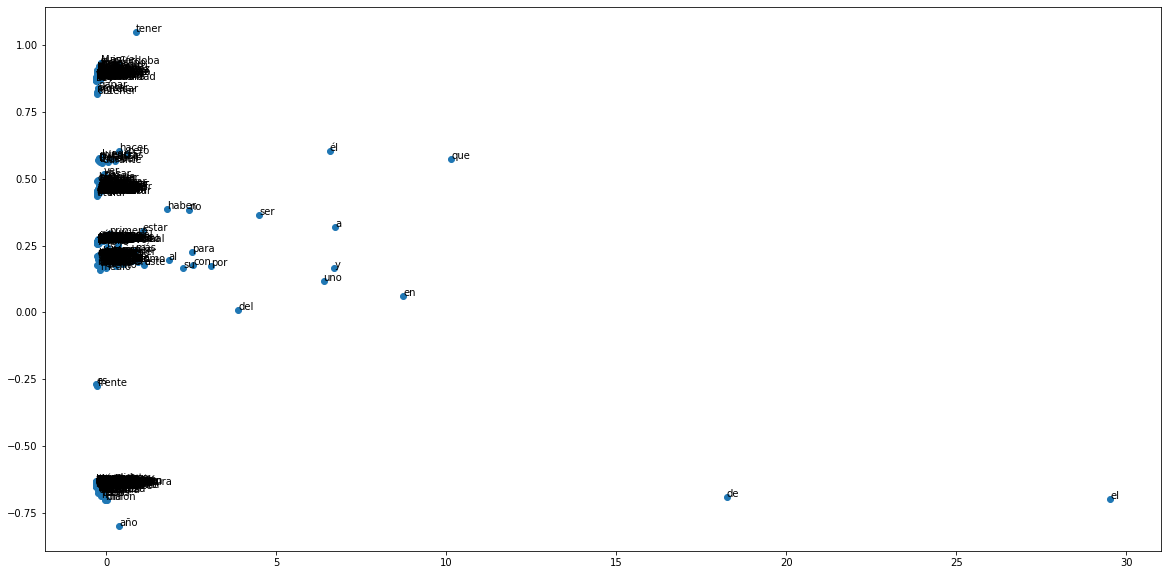

In [ ]:
x_axis = [point[0] for point in vectors_matrix_2d]
y_axis = [point[1] for point in vectors_matrix_2d]

fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x_axis, y_axis)

for i, key in enumerate(keys):
    ax.annotate(key, (x_axis[i], y_axis[i]))

In [ ]:
# kmeans, v_labels = clustering(vectors_matrix)
v_labels = clustering_2(10, vectors_matrix_2d)
print(clusters)

defaultdict(<class 'list'>, {9: ['él', 'que', 'a', 'el', 'ser', 'y', 'no', 'otro', 'estar', 'en', 'de', 'del', 'haber', 'uno', 'más', 'como', 'para', 'con', 'todo', 'ese', 'al', 'por', 'poder', 'este', 'su'], 2: ['sostener', 'ni', 'conocer', 'lograr', 'tanto', 'hablar', 'vivir', 'mismo', 'parecer', 'tratar', 'contra', 'creer', 'poner', 'trabajar', 'mantener', 'decidir', 'sumar', 'pedir', 'volver', 'ex', 'pasado', 'salir', 'esperar', 'participar', 'Ley', 'De', 'poco', 'comenzar', 'encontrar', 'afirmar', 'nacional', 'e', 'recibir', 'considerar', 'público', 'existir', 'indicar', 'último', 'permitir', 'agregar', 'Universidad', 'informar', 'mientras', 'terminar', 'señalar', 'pagar', 'Voz', 'presentar', 'quién'], 1: ['pareja', 'mujer', 'movimiento', 'tiempo', 'cosa', 'acuerdo', 'momento', 'duda', 'vida', 'manera', 'problema', 'través', 'sentido', 'razón', 'trabajo', 'proyecto', 'objetivo', 'forma', 'plazo', 'lado', 'interés', 'recurso', 'conflicto', 'general', 'ingreso', 'toma', 'institución

['es', 'frente']
defaultdict(<class 'list'>, {9: ['él', 'que', 'a', 'el', 'ser', 'y', 'no', 'otro', 'estar', 'en', 'de', 'del', 'haber', 'uno', 'más', 'como', 'para', 'con', 'todo', 'ese', 'al', 'por', 'poder', 'este', 'su'], 8: ['sostener', 'conocer', 'bien', 'pensar', 'hablar', 'cambiar', 'vivir', 'perder', 'después', 'crecer', 'tratar', 'menos', 'creer', 'elegir', 'económico', 'poner', 'trabajar', 'mantener', 'así', 'iniciar', 'volver', 'advertir', 'abrir', 'llamar', 'empezar', 'continuar', 'morir', 'casa', 'construir', 'ex', 'recordar', 'pasado', 'mejor', 'salir', 'esperar', 'admitir', 'responder', 'evitar', 'participar', 'generar', 'sufrir', 'mostrar', 'social', 'entender', 'poco', 'nuestro', 'comenzar', 'sentir', 'aparecer', 'antes', 'cumplir', 'encontrar', 'ocurrir', 'suceder', 'varios', 'afirmar', 'mayor', 'declarar', 'cordobés', 'resolver', 'implicar', 'aumentar', 'incluir', 'explicar', 'funcionar', 'apuntar', 'considerar', 'tras', 'casi', 'existir', 'indicar', 'último', 'apli

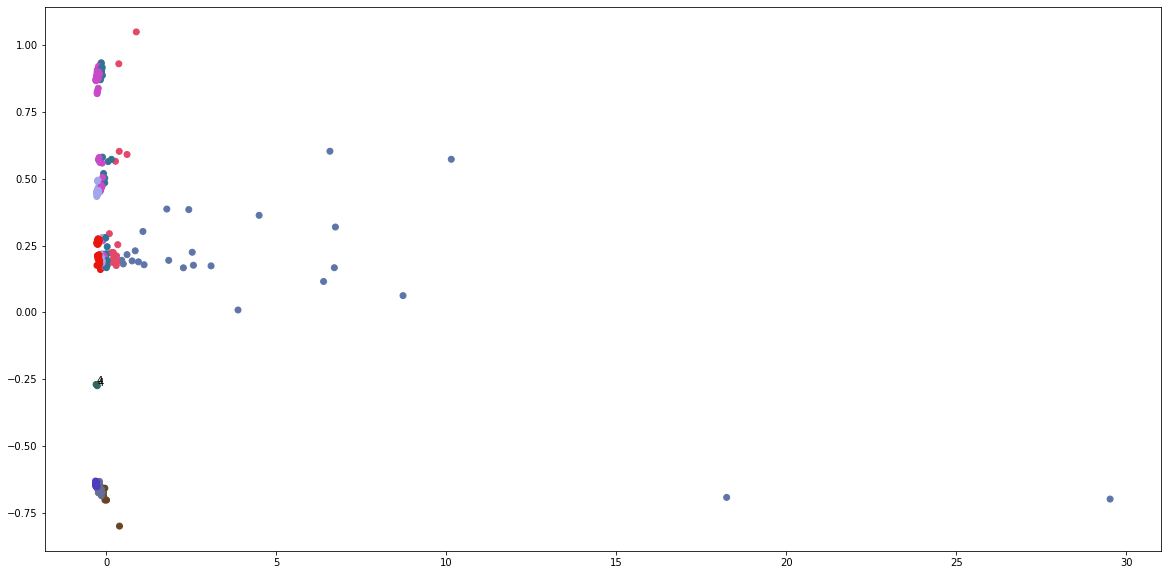

In [ ]:
set_labels = set(v_labels)
colors = defaultdict(int)
for label in set_labels:
    colors[label] = "#" + "".join([random.choice('0123456789ABCDEF') for _ in range(6)])

x_axis = [point[0] for point in vectors_matrix_2d]
y_axis = [point[1] for point in vectors_matrix_2d]

fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x_axis, y_axis, c=[colors[label] for label in v_labels])

clusters = defaultdict(list)
for i, label in enumerate(v_labels):
    clusters[label].append(keys[i])



Estoy clusterizando mal, creo que es por algun preprocesamiento mal hecho